In [1]:
from utils_project import *

from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stats import calc_perm_pvalue
from nlp import * 

def pairwise_annak_distances(X):
    n = len(X)
    annak_sim = np.zeros((n, n))
    X_rank = scipy.stats.rankdata(X) 
    for i in range(n):
        for j in range(n):
            if i < j:
                annak_sim[i,j] = annak_sim[j,i] = np.mean([X_rank[i], X_rank[j]]) / n
            elif i==j:
                annak_sim[i,j] = 1
    annak_dist = 1 - annak_sim
    return annak_dist

def get_sentiments(free_resps, preprocess=True):

    if isinstance(free_resps, np.ndarray):
        free_resps = free_resps.tolist()
    if preprocess:
        free_resps = [preprocess_text(fr, remove_stopwords=False, return_tokenized=False) for fr in free_resps]

    sentiments = {}
    for role, response in zip(character_roles, free_resps):
        try:
            sentiment_scores = SentimentIntensityAnalyzer().polarity_scores(response)
            sentiments.update({
                f'positive_{role}': sentiment_scores['pos'],
                f'negative_{role}': sentiment_scores['neg'],
                f'neutral_{role}': sentiment_scores['neu'],
                f'compound_{role}': sentiment_scores['compound']
            })
        except:
            keys = ['positive', 'negative', 'neutral', 'compound']
            sentiments.update({f'{key}_{role}': np.nan for key in keys})
    return sentiments

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


In [2]:
data_val   = sample_dict['Validation']['data']
ques_items = subset_df(data_val, fa_prefixes).iloc[:, 1:]

# get semantic features
data_dir  = f'{base_dir}/Data'
out_fname = f'{data_dir}/semantic_dict.pkl'

if os.path.exists(out_fname):
    
    semantic_dict = load_pickle(out_fname)

else:

    semantic_dict = {sub_id: {} for sub_id in data_val['sub_id'].values}

    for r, row in data_val.iterrows():

        sub_id     = row['sub_id']
        free_resps = row[[f'free_response_{role}' for role in character_roles]].values

        # sentiments & number of words
        semantic_dict[sub_id]['sentiments'] = pd.DataFrame(get_sentiments(free_resps, preprocess=True), index=[0])
        num_words_ = np.array([len(fr.split(" ")) for fr in free_resps])[np.newaxis,:]
        semantic_dict[sub_id]['num_words'] = pd.DataFrame(num_words_, columns=[f'num_words_{role}' for role in character_roles], index=[0])

        # get embeddings 
        semantic_dict[sub_id]['mlml12_embeddings']   = get_sentencetransformer_embeddings(free_resps, model='mlml12')
        semantic_dict[sub_id]['mpnet_embeddings']    = get_sentencetransformer_embeddings(free_resps, model='mpnet')
        semantic_dict[sub_id]['roberta_embeddings']  = get_sentencetransformer_embeddings(free_resps, model='roberta')
        semantic_dict[sub_id]['multi_qa_embeddings'] = get_sentencetransformer_embeddings(free_resps, model='multi_qa')
    
    pickle_file(semantic_dict, out_fname)


include_neutral = True
nchar = 6 if include_neutral else 5
sub_ids = semantic_dict.keys()

# number of words
num_words = np.array([semantic_dict[sub_id]['num_words'] for sub_id in sub_ids]).squeeze()
num_words = pd.DataFrame(num_words[:,:nchar], columns=[f'num_words_{role}' for role in character_roles[:nchar]])
data_val.loc[:, num_words.columns] = num_words
data_val['num_words_mean'] = np.mean(data_val[[f'num_words_{role}' for role in character_roles[:nchar]]], axis=1)

# sentiments
sentiments = pd.concat([semantic_dict[sub_id]['sentiments'] for sub_id in sub_ids]).reset_index(drop=True)
data_val.loc[:, sentiments.columns] = sentiments
data_val['positive_mean'] = np.mean(data_val[[f'positive_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['negative_mean'] = np.mean(data_val[[f'negative_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['neutral_mean']  = np.mean(data_val[[f'neutral_{role}' for role in character_roles[:nchar]]], axis=1)
data_val['compound_mean'] = np.mean(data_val[[f'compound_{role}' for role in character_roles[:nchar]]], axis=1)

# Embedding dissimilarities correlate with behavioral and subjective dissimilarities
Nice as a validation since it's unstructured - and kind of opens door to more NLP-like analyses of the fMRI data

mlml12
RSA Wilcoxon: W=18405.0, right-tailed p=0.003
RSA Wilcoxon: W=21613.5, right-tailed p=0.000
Correlation between taus: tau=0.096, right-tailed p=0.012

mpnet
RSA Wilcoxon: W=15783.5, right-tailed p=0.298
RSA Wilcoxon: W=19860.5, right-tailed p=0.001
Correlation between taus: tau=0.070, right-tailed p=0.051

roberta
RSA Wilcoxon: W=17472.0, right-tailed p=0.021
RSA Wilcoxon: W=18885.0, right-tailed p=0.015
Correlation between taus: tau=0.144, right-tailed p=0.000



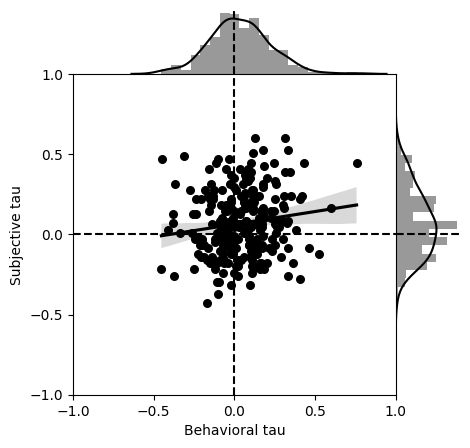

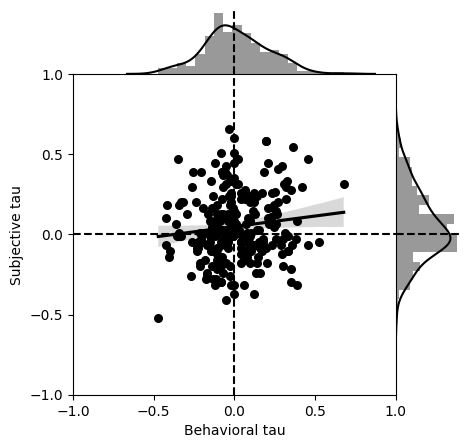

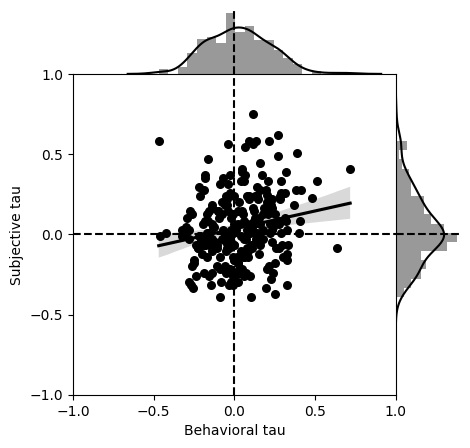

In [3]:
def plot_(x, y, 
          figsize=(5,5), 
          ax=None, color='grey', 
          density=False, regression=False):
    
    '''
    '''

    if density:
        xy = np.vstack([x, y])
        z  = gaussian_kde(xy)(xy)  # calculate the point density
        idx = z.argsort() # sort so that the bright spots are on top
        x, y, z = x[idx], y[idx], z[idx]

    # plot
    fig, axs = plt.subplots(2, 2, figsize=figsize, 
                            gridspec_kw={'hspace': 0, 'wspace': 0,
                                        'width_ratios': [5, 1], 'height_ratios': [1, 5]})
    axs[0,0].axis("off")
    axs[0,1].axis("off")
    axs[1,1].axis("off")
    axs[1,0].set_ylim([-1,1])
    axs[1,0].set_yticks([-1,-.5,0,.5,1])
    axs[1,0].set_xlim([-1,1])
    axs[1,0].set_xticks([-1,-.5,0,.5,1])
    axs[1,0].axhline(y=0, color='black', linestyle='--', zorder=-1)
    axs[1,0].axvline(x=0, color='black', linestyle='--', zorder=-1)

    sns.distplot(x, bins=20, ax=axs[0,0], color=color)
    axs[0,0].set_xlim([-1,1])
    axs[0,0].axvline(x=0, color='black', linestyle='--', zorder=-1)
    sns.distplot(y, bins=20, ax=axs[1,1], color=color, vertical=True)
    axs[1,1].set_ylim([-1,1])
    axs[1,1].axhline(y=0, color='black', linestyle='--', zorder=-1)

    if density:
        axs[1,0].scatter(x, y, c=z, s=100)
    else:
        axs[1,0].scatter(x, y, color=color, s=30)

    if regression: 
        sns.regplot(x=x, y=y, scatter=False, color='black', ax=axs[1,0])
    
    return axs

# compute correlations
models = ['mlml12', 'mpnet', 'roberta']
for model in models:

    print(model)

    semantic_rdvs = [symm_mat_to_ut_vec(pairwise_distances(embd[:nchar,:], metric='cosine')) for embd in [semantic_dict[sub_id][f'{model}_embeddings'] for sub_id in sub_ids]]
    beh_rdvs      = [symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in get_coords(data_val, which='task', include_neutral=include_neutral)]
    dots_rdvs     = [symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in get_coords(data_val, which='dots', include_neutral=include_neutral)]
    taus = np.array([[kendalltau(semantic_rdvs[i], beh_rdvs[i])[0], kendalltau(semantic_rdvs[i], dots_rdvs[i])[0]] for i in range(len(semantic_rdvs))])

    axs = plot_(taus[:,0], taus[:,1], color="black", regression=True) # sample_colors[1]
    axs[1,0].set_xlabel('Behavioral tau')
    axs[1,0].set_ylabel('Subjective tau');

    taus = np.array(taus)
    for i, taus_ in enumerate(taus.T):
        W, p = wilcoxon(isfinite(taus_)[0], alternative='greater')
        print(f'RSA Wilcoxon: W={W}, right-tailed p={p:.3f}')
    tau, p = kendalltau(taus[:,0], taus[:,1], alternative='greater')
    print(f'Correlation between taus: tau={tau:.3f}, right-tailed p={p:.3f}\n')

# Sentiment varies over the characters
The boss is clearly in a different category than the other characters...

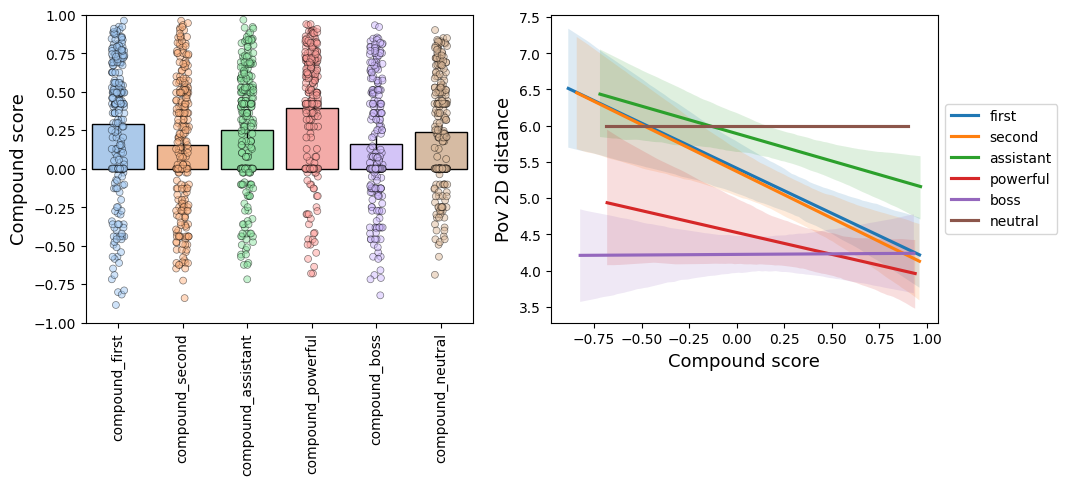

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

ax = axs[0]
sns.barplot(data=data_val[[f'compound_{role}' for role in character_roles[:nchar]]], 
            palette='pastel', edgecolor='black', errcolor='black', errwidth=1, 
            ax=ax)
sns.stripplot(data=data_val[[f'compound_{role}' for role in character_roles[:nchar]]], 
              palette='pastel', alpha=0.5, edgecolor='black', linewidth=0.5,
              ax=ax)
ax.set_ylabel('Compound score', fontsize=label_fontsize)
ax.set_ylim(-1, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axs[1]
for role in character_roles[:nchar]:
    sns.regplot(data=data_val, x=f'compound_{role}', y=f'pov_2d_dist_{role}', scatter=False, ax=ax, label=role)
ax.set_xlabel('Compound score', fontsize=label_fontsize)
ax.set_ylabel('Pov 2D distance', fontsize=label_fontsize)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Negative sentiments
- social network size, pov dist, social factor and mood are all associated w/ sentiment 
    - no significant relationship with affiliation or power, but trends... another example of how collapsing into pov dist might improve interpretability
- number of words positively associated: more happy, more writing


- TODO other things to try
    - does pov distance have an anna karenina kind of thing going on? or some other structure we can probe with IS-RSA

,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
1,pov_2d_dist_mean_mean,228.0,0.153,803.24,707.63,-0.1453,0.0637,-0.2709,-0.0198,-2.2807,2.3491e-02,0.0117,9.8825e-01
2,factor_social_quartimax_thresh25,228.0,0.153,803.24,707.63,-0.0656,0.0624,-0.1885,0.0572,-1.0526,2.9366e-01,0.1468,8.5317e-01
3,factor_mood_quartimax_thresh25,228.0,0.153,803.24,707.63,-0.1088,0.0626,-0.2322,0.0145,-1.7386,8.3458e-02,0.0417,9.5827e-01
4,factor_compulsive_quartimax_thresh25,228.0,0.153,803.24,707.63,0.0108,0.0644,-0.1161,0.1376,0.1672,8.6737e-01,0.5663,4.3369e-01
5,num_words_mean,228.0,0.153,803.24,707.63,0.3978,0.0653,0.2692,0.5264,6.0941,4.6461e-09,1.0000,2.3231e-09


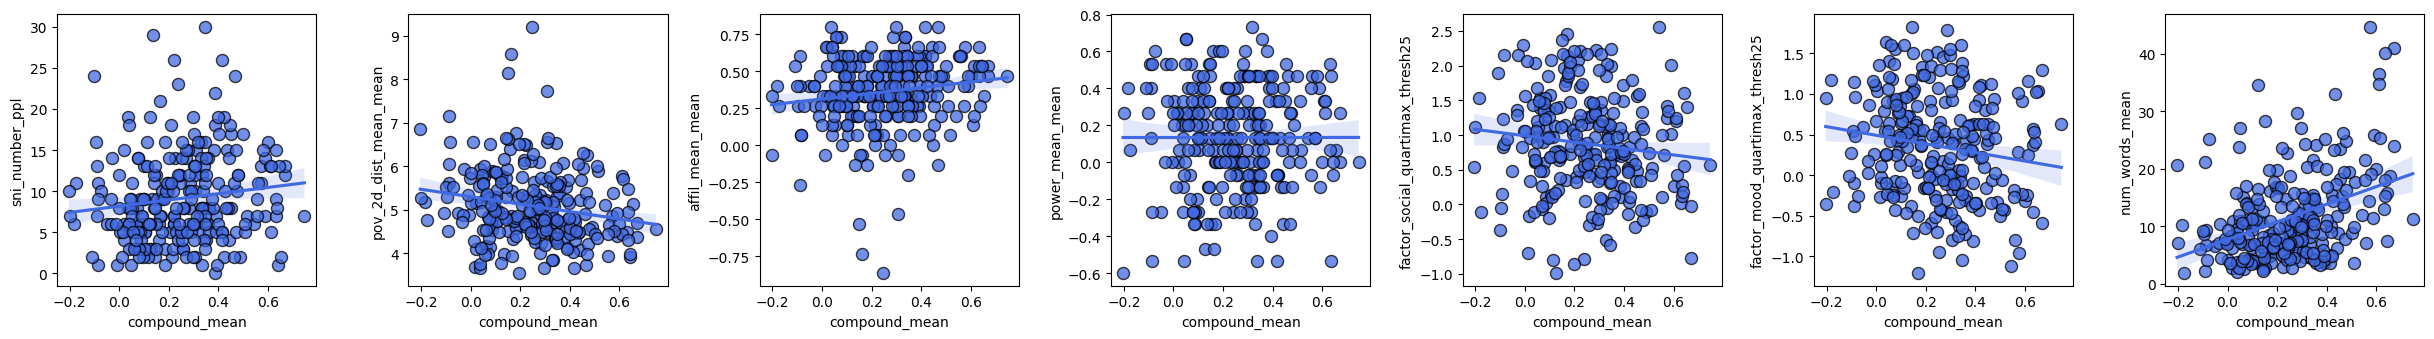

In [5]:
# plot individually
yvars = ['sni_number_ppl', 'pov_2d_dist_mean_mean', 'affil_mean_mean', 'power_mean_mean', social_factor, mood_factor, 'num_words_mean'] # 
fig, axs = plt.subplots(1, len(yvars), figsize=(3.5*len(yvars), 3.5))
for i, yvar in enumerate(yvars):
    plot_regplot(data_val['compound_mean'], data_val[yvar], color=sample_colors[1], ax=axs[i])
plt.tight_layout()

# run ols
xvars   = ['pov_2d_dist_mean_mean', social_factor, mood_factor, compulsive_factor, 'num_words_mean', 'memory_mean']
results = run_ols(X=xvars, y='compound_mean', data=data_val,  covariates=all_controls)[0]
display(results[results['x'].isin(xvars)].iloc[:,2:])

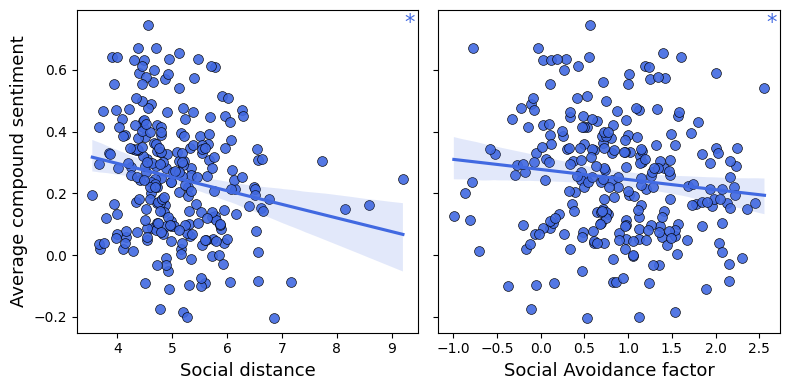

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), sharey=True)

ax = axs[0]
sns.regplot(data=data_val, x='pov_2d_dist_mean_mean', y='compound_mean', scatter=True,
            scatter_kws={'alpha':0.9, 's':50, 'edgecolor': 'black', 'linewidth':0.5},
            color=sample_colors[1], ax=ax)
ax.set_xlabel('Social distance', fontsize=label_fontsize)
ax.set_ylabel('Average compound sentiment', fontsize=label_fontsize)
plot_significance(ax, 0.019*2, sig_level=4, x=0.96, y=0.99, dx=-0.0275, color=sample_colors[1], fontsize=title_fontsize)

ax = axs[1]
sns.regplot(data=data_val, x=social_factor, y='compound_mean', scatter=True,
            scatter_kws={'alpha':0.9, 's':50, 'edgecolor': 'black', 'linewidth':0.5},
            color=sample_colors[1], ax=ax)
ax.set_xlabel('Social Avoidance factor', fontsize=label_fontsize)
ax.set_ylabel('', fontsize=label_fontsize)
plot_significance(ax, 0.0055*2, sig_level=4, x=0.96, y=0.99, dx=-0.0275, color=sample_colors[1], fontsize=title_fontsize)
plt.tight_layout()

In [7]:
beh_xys    = get_coords(data_val, which='task', include_neutral=include_neutral)
beh_rdvs   = np.array([symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in beh_xys])
dot_xys    = get_coords(data_val, which='dots', include_neutral=include_neutral)
dot_rdvs   = np.array([symm_mat_to_ut_vec(pairwise_distances(xys, metric='euclidean')) for xys in dot_xys])
sentiments = data_val[[f'compound_{role}' for role in character_roles[:nchar]]].values  
sentiments_rdvs = np.array([symm_mat_to_ut_vec(pairwise_distances(sentiments[i,:][:, np.newaxis], metric='euclidean')) for i in range(sentiments.shape[0])])

beh_taus = np.array([kendalltau(beh_rdvs[i], sentiments_rdvs[i])[0] for i in range(len(beh_rdvs))])
dot_taus = np.array([kendalltau(dot_rdvs[i], sentiments_rdvs[i])[0] for i in range(len(dot_rdvs))])
w, p = wilcoxon(beh_taus, alternative='greater')
print(f'Wilcoxon: W={w}, right-tailed p={p:.3f}')
w, p = wilcoxon(dot_taus, alternative='greater')
print(f'Wilcoxon: W={w}, right-tailed p={p:.3f}')

Wilcoxon: W=15242.5, right-tailed p=0.690
Wilcoxon: W=19875.5, right-tailed p=0.001


# Predict social avoidance from NLP, behavioral features
- can predict the sentiment score from the vectors alone (not surprising but maybe useful)

In [47]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
regression_models = {
    'Ridge': Ridge(alpha=0.1),
    'Lasso': Lasso(alpha=0.1),
    # 'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000),
    'SVM': SVR(kernel='rbf'),
    'SVM_L2': SVR(kernel='rbf', C=10),
    'PCR': make_pipeline(PCA(n_components=100), LinearRegression()),
    'PC_SVM': make_pipeline(PCA(n_components=100), SVR(kernel='rbf')),
    'PLSR': PLSRegression(n_components=100),  # TODO: should choose the n_components with CV
    # basically something like PCR: creates latent variables from predictors, then builds a linear regression model from these predictors
}

from sklearn.base import clone

def regression_cv(model, X, y, kf):
    """
    Perform k-fold cross-validation for a given model and dataset.

    :param model: The machine learning model to be evaluated.
    :param X: The feature matrix.
    :param y: The target vector.
    :param kf: KFold cross-validation splitter.
    
    :return: A tuple containing the true labels, predicted labels, and fold indices.
    """
    y_real, y_pred, folds = [], [], []

    for k, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # normalize X_train and then apply the same transformation to X_test
        scaler  = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

        # Clone the model to ensure the original model is not altered
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)

        y_real.extend(y_test)
        y_pred.extend(cloned_model.predict(X_test).flatten())
        folds.extend([k] * len(y_test))  # Track fold number for coloring

    return y_real, y_pred, folds

def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


Number of observations: 255, Number of predictors: 384
Ridge: C.V. RMSE: 1.294; rho=0.006; r=0.027
Lasso: C.V. RMSE: 0.720; rho=0.000; r=0.031
SVM: C.V. RMSE: 0.726; rho=0.116; r=0.109
SVM_L2: C.V. RMSE: 0.748; rho=0.082; r=0.070
PCR: C.V. RMSE: 0.849; rho=0.069; r=0.063
PC_SVM: C.V. RMSE: 0.729; rho=0.132; r=0.129
PLSR: C.V. RMSE: 1.300; rho=0.006; r=0.027


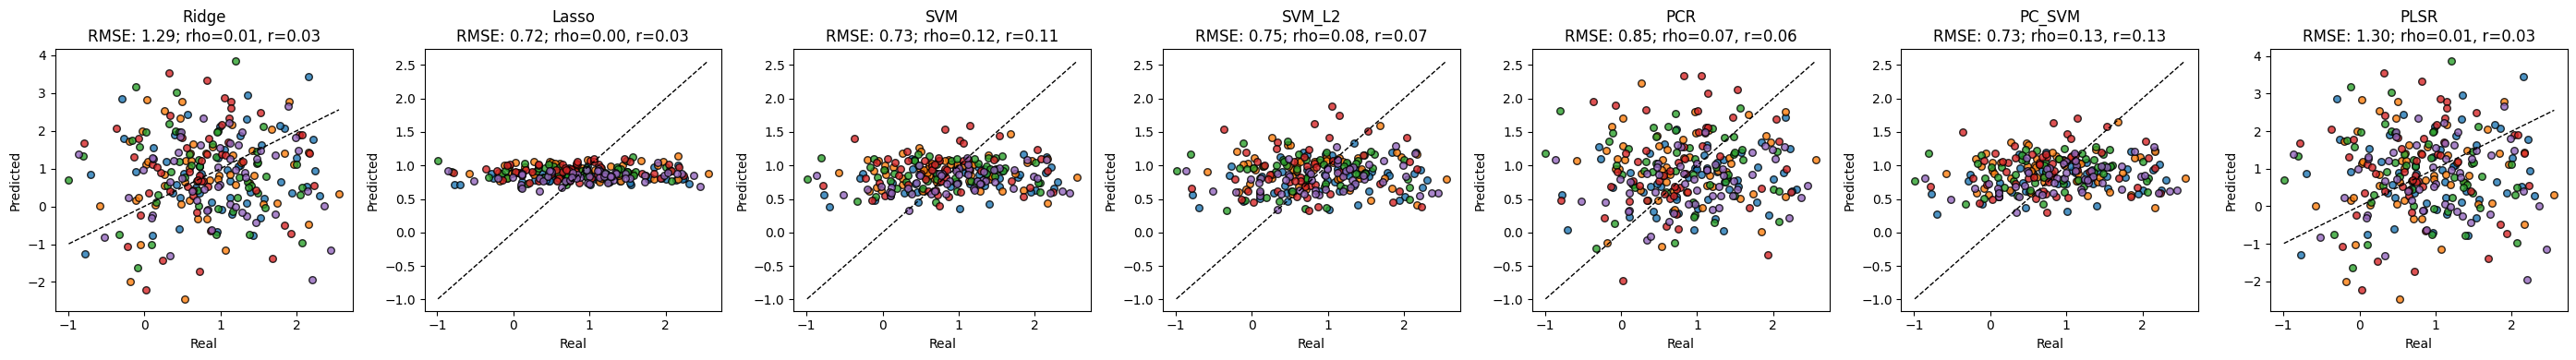

In [48]:
X = np.array([np.mean(semantic_dict[sub_id]['mlml12_embeddings'], axis=0) for sub_id in sub_ids])
y = data_val[social_factor].values
assert X.shape[0] == y.shape[0]

n, k = X.shape
print(f'Number of observations: {n}, Number of predictors: {k}')

fig, axs = plt.subplots(1, len(regression_models), figsize=(4*len(regression_models), 4))
n_perms  = 1000
n_splits = 5
colors = sns.color_palette(n_colors=n_splits) 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for m, (model_name, model) in enumerate(regression_models.items()):

    y_real, y_pred, folds = regression_cv(model, X, y, kf)
    rmse   = np.sqrt(mean_squared_error(y_real, y_pred))
    r, p   = scipy.stats.pearsonr(y_real, y_pred)
    rho, p = scipy.stats.spearmanr(y_real, y_pred)
    print(f"{model_name}: C.V. RMSE: {rmse:.3f}; rho={rho:.3f}; r={r:.3f}")

    # # permutation test
    # perm_rhos = []
    # for perm in range(n_perms):
    #     print(f'\rPermutation {perm + 1}/{n_perms}', end='\r')
    #     y_real, y_pred, folds = regression_cv(model, X, np.random.permutation(y), kf)
    #     perm_rhos.append(scipy.stats.spearmanr(y_real, y_pred)[0])
    # perm_p = calc_perm_pvalue(rho, perm_rhos, alternative='greater')

    # plot
    ax = axs[m]
    for fold_idx, color in enumerate(colors):
        fold_mask = np.array(folds) == fold_idx
        sns.scatterplot(x=np.array(y_real)[fold_mask], y=np.array(y_pred)[fold_mask],
                        color=color, edgecolor='black', linewidth=1, s=30, alpha=0.8, 
                        ax=ax, label=f'{fold_idx + 1}')
    ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=1)
    ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}; rho={rho:.2f}, r={r:.2f}')
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicted')
    ax.get_legend().remove()
    # ax.legend(title='CV Fold', bbox_to_anchor=(.75, .5), loc='upper left')
plt.tight_layout()

# Ideas to try
Classify sentiment of a given character based on behavior? 

### IS-RSA Anna Karenina effects for social avoidance, sentiment

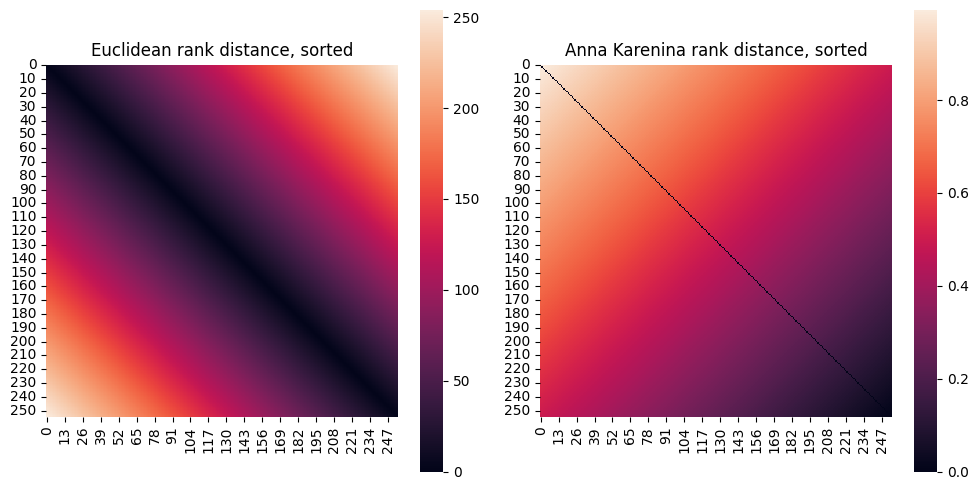

In [6]:
# plot the similarity matrices, sorted by compound score...
fig, axs = plt.subplots(1,2, figsize=(10,5))

compound_ranks = data_val[['compound_mean']].rank()

# Euclidean: Ps with nearby scores should be more similar to each other
ax = axs[0]
ax.set_title('Euclidean rank distance, sorted')
compound_rdm = pairwise_distances(compound_ranks)
sns.heatmap(sort_symm_mat(compound_rdm, data_val[['compound_mean']].values.flatten()), square=True, ax=ax)

# Anana Karenina: high scorers should be more similar to each other than low scorers are to each other
ax = axs[1]
ax.set_title('Anna Karenina rank distance, sorted')
compound_rdm = pairwise_annak_distances(compound_ranks)
sns.heatmap(sort_symm_mat(compound_rdm, data_val[['compound_mean']].values.flatten()), square=True, ax=ax)
plt.tight_layout()


In [6]:
def intersubject_rsa(x, y, y_metric='cosine', n_perms=1000):
    
    y_rdm = pairwise_distances(y, metric=y_metric)
    y_rdv = symm_mat_to_ut_vec(y_rdm)

    # compute euclidean distance rdm for x
    x_rdm = pairwise_distances(x, metric='euclidean')
    x_rdv = symm_mat_to_ut_vec(x_rdm)

    # compute anna karenina distance rdm for x 
    x_anna_rdm = pairwise_annak_distances(x)
    x_anna_rdv = symm_mat_to_ut_vec(x_anna_rdm)

    # loop over x rdms and calculate correlations w/ y
    res = []
    for x_metric, rdv in {'euclidean': x_rdv, 'anna karenina': x_anna_rdv}.items():
        tau = kendalltau(y_rdv, rdv)[0]
        perm_taus = np.array([kendalltau(y_rdv, symm_mat_to_ut_vec(perm))[0] 
                              for perm in permute_symm_mat(x_rdm, n_perms=n_perms)])
        p = calc_perm_pvalue(tau, perm_taus, alternative='two-sided')
        res.append([x_metric, y_metric, tau, p])
    return pd.DataFrame(res, columns=['x_metric', 'y_metric', 'tau', 'p'])

avg_embeddings = np.array([semantic_dict[sub_id]['mlml12_embeddings'].mean(axis=0)
                           for sub_id in semantic_dict.keys()])
behav_xy = data_val[['affil_mean_mean', 'power_mean_mean']]
dots_xy  = data_val[['dots_affil_mean', 'dots_power_mean']]
sentiment_compound = data_val[['compound_mean']] # high is positive
social_avoidance   = data_val[[social_factor]] # high is negative
ques_items = subset_df(data_val, fa_prefixes).iloc[:, 1:]
dict_ = {'behavior': behav_xy, 'dots': dots_xy,
         'semantic': avg_embeddings, 
         'sentiment': sentiment_compound, 
         'social avoidance': social_avoidance,
         'questionnaires': ques_items}

In [16]:
comparisons = [['sentiment', 'behavior'], 
               ['sentiment', 'dots'],
               ['sentiment', 'semantic'], 
               ['sentiment', 'questionnaires'],
               ['social avoidance', 'behavior'],
               ['social avoidance', 'dots'],
               ['social avoidance', 'semantic'],
               ['social avoidance', 'sentiment']] # order matters....
results = []
for x, y in comparisons:
    y_metric = 'cosine' if y=='semantic' else 'euclidean'
    res_df = intersubject_rsa(dict_[x], dict_[y], y_metric=y_metric)
    res_df.insert(0, 'x', x)
    res_df.insert(1, 'y', y)
    results.append(res_df)
pd.concat(results)

,x,y,x_metric,y_metric,tau,p
0,sentiment,behavior,euclidean,euclidean,0.005,0.701
1,sentiment,behavior,anna karenina,euclidean,0.059,0.002
0,sentiment,dots,euclidean,euclidean,-0.002,0.825
1,sentiment,dots,anna karenina,euclidean,0.048,0.010
0,sentiment,semantic,euclidean,cosine,0.033,0.032
1,sentiment,semantic,anna karenina,cosine,0.056,0.002
0,sentiment,questionnaires,euclidean,euclidean,-0.017,0.384
1,sentiment,questionnaires,anna karenina,euclidean,0.048,0.012
0,social avoidance,behavior,euclidean,euclidean,0.029,0.076
1,social avoidance,behavior,anna karenina,euclidean,-0.029,0.052


### Social avidance correlates with semantic differences between characters
- more avoidance, less similarity between the characters 
- Anna Karenina effect: more ways to dislike the characters than to like them?

In [6]:
assert np.all(data_val['sub_id'].values == [sub_id for sub_id in sub_ids])
data_val['avg_cosine_sim'] = [np.mean(1 - symm_mat_to_ut_vec(pairwise_distances(semantic_dict[sub_id]['mlml12_embeddings'], metric='cosine'))) for sub_id in sub_ids]

# run ols
Xs = [social_factor, 'num_words_mean'] # 'compound_mean', 
res = run_ols(X=Xs, y='avg_cosine_sim',
              data=data_val, 
              covariates=all_controls)[0]
display(res[res['x'].isin(Xs)])

# # plot
# fig, axs = plt.subplots(1, len(Xs), figsize=(4*len(Xs), 4), sharey=True)
# for i, x in enumerate(Xs):
#     ax = axs[i]
#     plot_regplot(data_val[x], data_val[social_factor], color=sample_colors[1], ax=ax)
#     ax.set_xlabel(x, fontsize=label_fontsize)
#     ax.set_ylabel('Social Avoidance', fontsize=label_fontsize)
# plt.tight_layout()
# tau, p = kendalltau(data_val['avg_cosine'], data_val[social_factor], alternative='greater')
# plot_significance(ax, p, color=sample_colors[1], x=0.07, dx=0.025)

,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
1,Intercept + factor_social_quartimax_thresh25 +...,avg_cosine_sim,factor_social_quartimax_thresh25,231.0,0.025,825.89,740.9,-0.1091,0.0647,-0.2365,0.0183,-1.6877,0.0928,0.0464,0.9536
2,Intercept + factor_social_quartimax_thresh25 +...,avg_cosine_sim,num_words_mean,231.0,0.025,825.89,740.9,0.1879,0.0697,0.0506,0.3253,2.6955,0.0075,0.9962,0.0038
